<a href="https://colab.research.google.com/github/owenwang05/dish-detect/blob/main/feature_extraction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dish Detect:** Feature-extraction model

**End-to-end CNN Image Classification Model**

Feature extraction model based on EfficientNetB1 trained and evaluated on the Food101 Dataset

## Initial Setup

In [ ]:
# Check the GPU (must be T4 for mixed precision training)
!nvidia-smi

Sat Aug 24 00:55:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required packages
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
# Import addiitonal packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

In [ ]:
# Import aelper functions
!wget https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py

--2024-08-24 00:55:58--  https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-24 00:55:58 (115 MB/s) - ‘helper_function.py’ saved [10246/10246]



In [ ]:
# Load helper functions
from helper_function import plot_loss_curves, load_and_prep_image

## Prepare Data

The dataset being used is Food101, which is available on TensorFlow

The dataset is imported using the `TensorFlow Datasets` module

In [ ]:
# Check if Food101 dataset is avaliable
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Import data set
(train_data_initial, test_data_initial), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True) # provides ds_info variable

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.S46I39_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.S46I39_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [34]:
# Features of Food101 fomr TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [35]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [59]:
# Take on sample of the train data
train_data_sample = train_data_initial.take(1)
train_data_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [62]:
# Output info about the training sample
for image, label in train_data_sample:
  print(f"Image shape: {image.shape}")
  print(f"Image datatype: {image.dtype}")
  print(f"Target class from Food101: {class_names[label]}")

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class from Food101: huevos_rancheros
Image shape: (384, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class from Food101: pizza
Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class from Food101: chocolate_cake


(-0.5, 511.5, 511.5, -0.5)

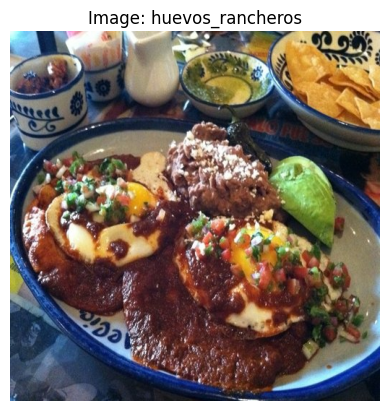

In [ ]:
# Plot the image
plt.imshow(image)
plt.title(f"Image: {class_names[label]}")
plt.axis(False)

## Preprocess Data

Current Data
* `uint8` datatype
* Different sized tensors
* Unscaled (0-255)

Model Wants
* `float` datatype
* Same sized tensors
* Normailzied

In [ ]:
# Create preprocessing function
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [ ]:
# Test preprocessing function
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float16, numpy=
array([[[230.6  , 253.6  , 251.   ],
        [223.   , 255.   , 252.2  ],
        [207.1  , 255.   , 250.4  ],
        ...,
        [140.6  , 129.5  , 121.25 ],
        [121.1  , 115.25 , 116.94 ],
        [ 83.94 ,  83.06 ,  89.6  ]],

       [[221.5  , 254.4  , 253.4  ],
        [214.5  , 255.   , 253.9  ],
        [198.4  , 254.6  , 252.   ],
        ...,
        [208.6  , 195.9  , 173.4  ],
        [197.   , 190.1  , 174.9  ],
        [175.5  , 171.6  , 161.2  ]],

       [[204.2  , 253.4  , 249.6  ],
        [198.8  , 254.6  , 251.2  ],
        [185.   , 251.8  , 252.2  ],
        ...,
        [222.5  , 207.5  , 169.4  ],
        [216.5  , 205.   , 172.   ],
        [215.5  , 207.9  , 177.6  ]],

       ...,

       [[ 47.12 ,  81.06 , 121.2  ],
        [ 30.4  ,  63.62 , 101.3  ],
        [127.4  , 158.9  , 193.   ],
        ...,
        [  3.953,  11.95 ,  23.38 ],
        [  2.27 ,  10.33 ,  21.22 ],
        [  6.863,  16.0

## Batch and Prepare Data

*   `Parallelize` - allows for parallel computing when mapping data to preprocess
*   `Buffer Size` - number of elements from which the next element is randomly picked
*   `Prefetch` - prepare second batch while computing patterns on current batch


In [ ]:
train_data = train_data_initial.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data_initial.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_data_initial

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Create Data Augmentation Layer

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
], name="data_augmentation")

## Create Modelling Callbacks

* `Model Checkpoint`- used to save checkpoints during training
* `Early Stopping` - used to stop training when a matric stops improving
* `ReduceLRonPlateau` - used to reduce LR when metric has stopped improving

In [ ]:
# Model Checkpoint Callback
checkpoint_path = "model_checkpoints/cp.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         verbose=1)

In [ ]:
# Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,
                                                           patience=3,
                                                           verbose=1,
                                                           monitor="val_accuracy")

In [ ]:
# ReduceLROnPlateau Callback
lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-7,
                                                patience=0,
                                                verbose=1)

## Setup Mixed Precision Training

allows the model to use `16-bit` floating point numbers to read/write to memory faster

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build Model

In [40]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# Input and data augmentation
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)

# Define functional layer
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)

# Define output layer
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

In [41]:
# Model Summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,704,620 (25.58 MB)

 Trainable params: 6,642,565 (25.34 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [42]:
# Base Model Summary
base_model.summary()

Model: "efficientnetb1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, None, None, 3)  │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, None, None, 3)  │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 6,513,184 (24.85 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [44]:
# Fit the Model
history = model.fit(train_data,
                    epochs=20,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback,
                               early_stopping_callback,
                               lower_lr])

Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4438 - loss: 2.3069
Epoch 1: val_accuracy improved from -inf to 0.67558, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 317s 133ms/step - accuracy: 0.4439 - loss: 2.3066 - val_accuracy: 0.6756 - val_loss: 1.1979 - learning_rate: 0.0010
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6796 - loss: 1.2177
Epoch 2: val_accuracy improved from 0.67558 to 0.69253, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 258s 109ms/step - accuracy: 0.6797 - loss: 1.2177 - val_accuracy: 0.6925 - val_loss: 1.1341 - learning_rate: 0.0010
Epoch 3/20
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7319 - loss: 0.9884
Epoch 3: val_accuracy improved from 0.69253 to 0.72749, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 257s 108ms/step - accuracy: 0.7319 - loss: 0.9883 - val_accuracy: 0.7275 - val_loss: 1.0382 - le

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9594 - loss: 0.1411
Epoch 8: val_accuracy improved from 0.83448 to 0.84799, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 258s 109ms/step - accuracy: 0.9594 - loss: 0.1411 - val_accuracy: 0.8480 - val_loss: 0.6421 - learning_rate: 4.0000e-05
Epoch 9/20
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9698 - loss: 0.1087
Epoch 9: val_accuracy did not improve from 0.84799

Epoch 9: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 110ms/step - accuracy: 0.9698 - loss: 0.1086 - val_accuracy: 0.8408 - val_loss: 0.6735 - learning_rate: 4.0000e-05
Epoch 10/20
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9747 - loss: 0.0933
Epoch 10: val_accuracy did not improve from 0.84799

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 257s 108ms/step - accuracy: 0.9748 - loss: 0

## Evaluate Model
*`loss curves` -

*`confusion matrix`

*`f1 scores`


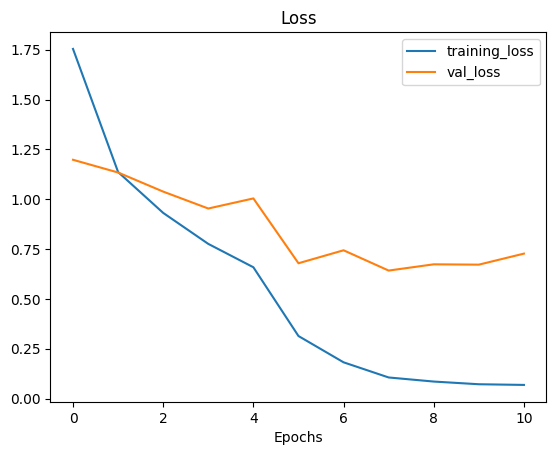

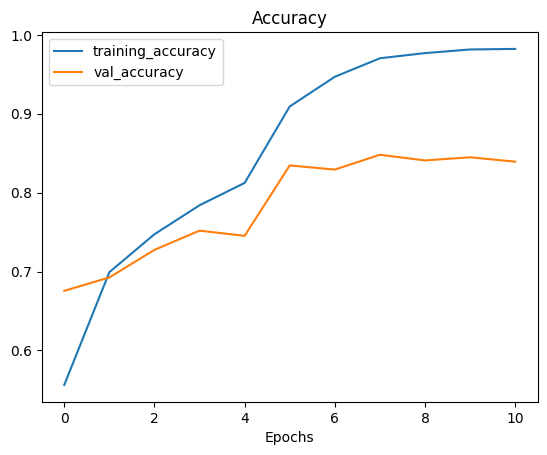

In [45]:
plot_loss_curves(history)

In [46]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.8440 - loss: 0.6622


[0.67411208152771, 0.8420594334602356]

In [47]:
# Get Probability Matrix
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs), pred_probs.shape

790/790 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step


(25250, (25250, 101))

In [48]:
# Get Prediciton
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [49]:
# Getting true labels for the test_data
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [50]:
# Compute Accuracy Score
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.842059405940594

In [51]:
# Create confusion matrix
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

In [52]:
# Plot F1 Scores
from sklearn.metrics import classification_report
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [53]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6,
 'baby_back_ribs': 0.8483606557377049,
 'baklava': 0.8995983935742972,
 'beef_carpaccio': 0.8796844181459568,
 'beef_tartare': 0.7976424361493123,
 'beet_salad': 0.7673469387755101,
 'beignets': 0.8560311284046693,
 'bibimbap': 0.930327868852459,
 'bread_pudding': 0.6639839034205232,
 'breakfast_burrito': 0.7663157894736842,
 'bruschetta': 0.7815126050420168,
 'caesar_salad': 0.875717017208413,
 'cannoli': 0.9036144578313253,
 'caprese_salad': 0.8543307086614174,
 'carrot_cake': 0.8031496062992125,
 'ceviche': 0.7499999999999999,
 'cheesecake': 0.7391304347826088,
 'cheese_plate': 0.891170431211499,
 'chicken_curry': 0.8216432865731463,
 'chicken_quesadilla': 0.8616600790513834,
 'chicken_wings': 0.8823529411764707,
 'chocolate_cake': 0.7560975609756098,
 'chocolate_mousse': 0.6666666666666667,
 'churros': 0.9018036072144289,
 'clam_chowder': 0.900398406374502,
 'club_sandwich': 0.8767676767676768,
 'crab_cakes': 0.7768924302788844,
 'creme_brulee': 0.923076923076923

In [54]:
report_df = pd.DataFrame(class_f1_scores, index = ['f1-scores']).T
report_df = report_df.sort_values("f1-scores", ascending=True)

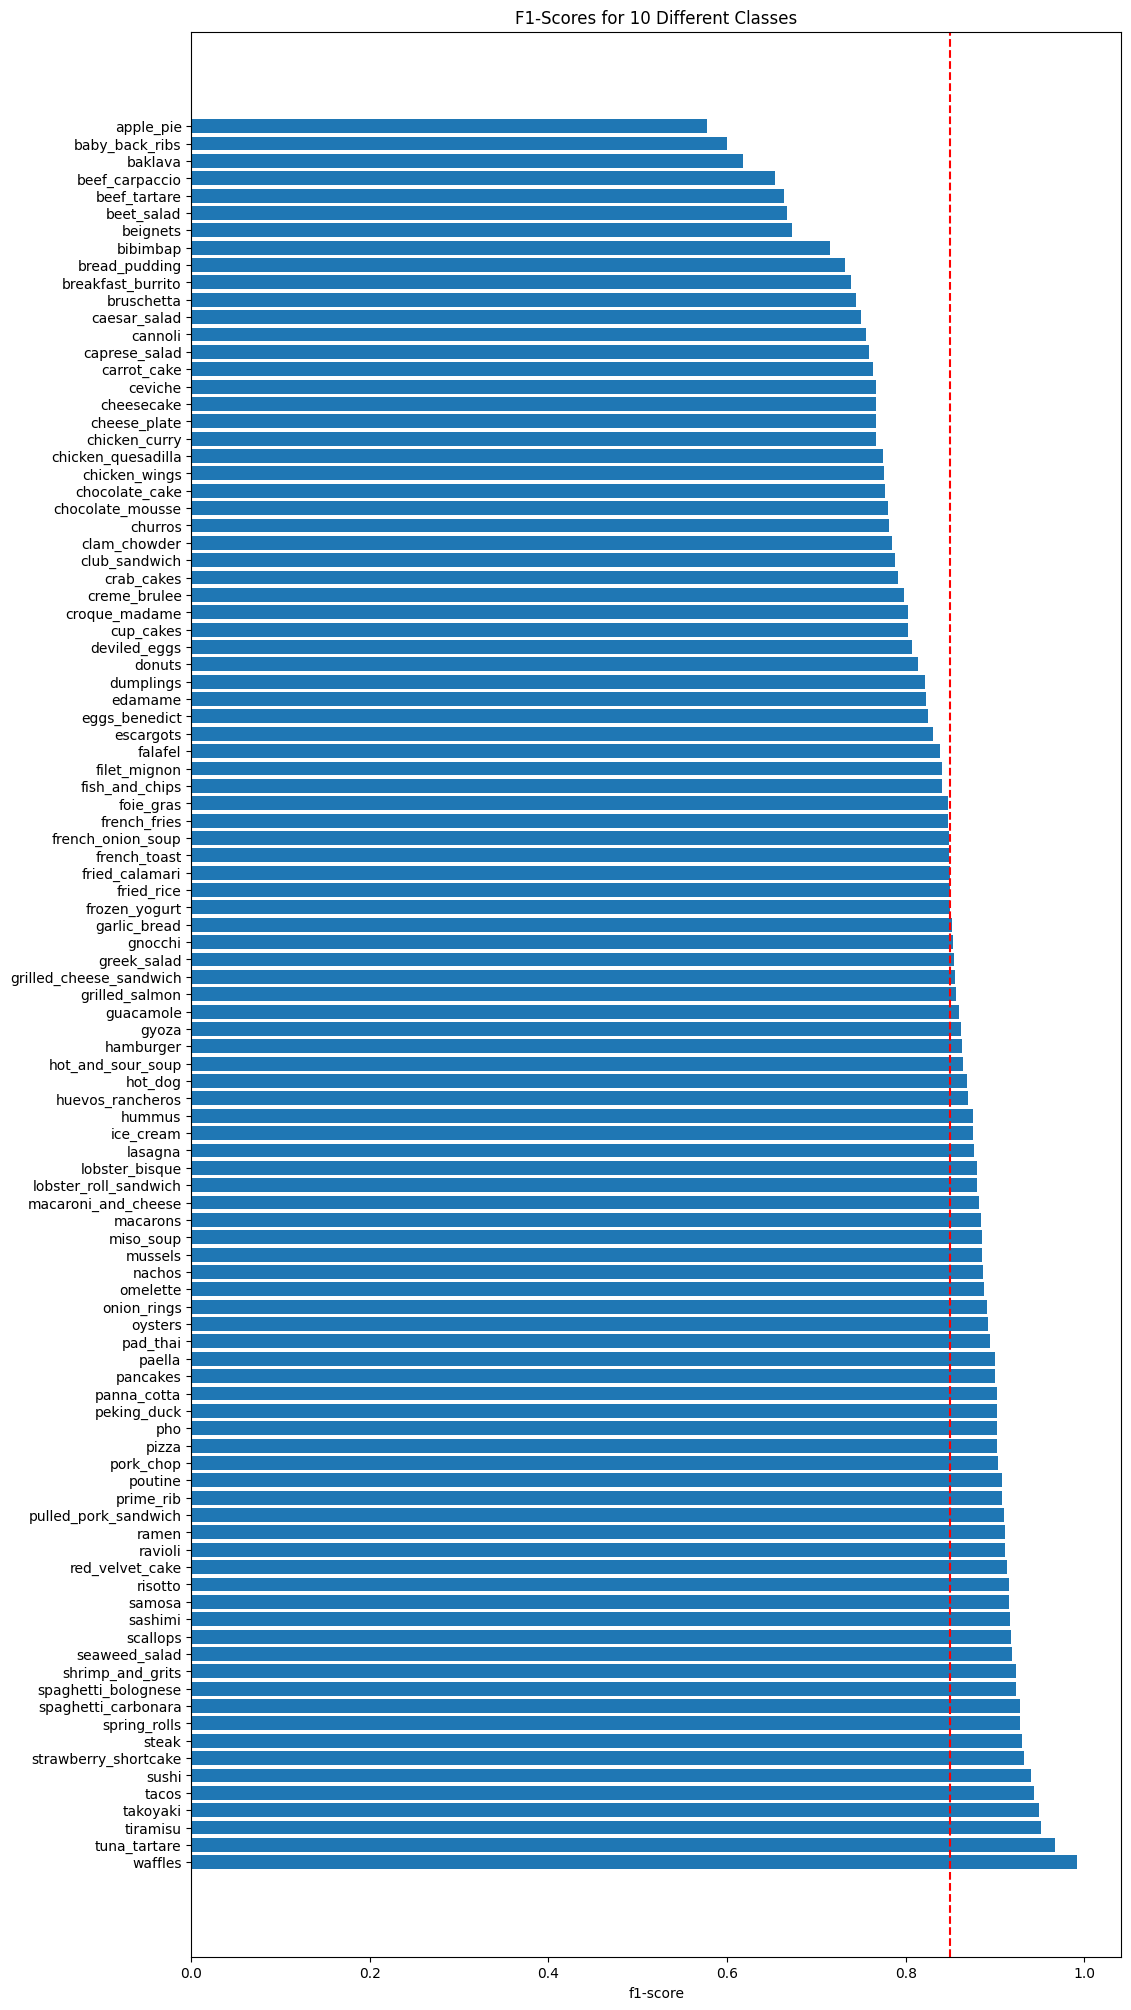

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(report_df)), report_df["f1-scores"].values)
ax.set_yticks(range(len(report_df)))
plt.axvline(x=0.85, linestyle='--', color='r')
ax.set_yticklabels(class_names)
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

## Save and Export Model

In [56]:
# Saving the model
model.save("/content/drive/My Drive/FinalModel.h5")

In [57]:
# Saving the model
model.save("FoodVision.h5")